In [1]:
%matplotlib inline

import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

The main assumption of this approach is: **similar users rate similar movies similarly.**

## Loading 1M movielens dataset

In [2]:
!ls 

KNN-approach.ipynb        ml-1m
dataset_exploration.ipynb ml-20m


In [3]:
path = 'ml-1m/'

In [57]:
movies = pd.read_csv(path+'movies.dat', sep='::', engine='python')
ratings = pd.read_csv(path+'ratings.dat', sep='::', engine='python')
users = pd.read_csv(path+'users.dat', sep='::', engine='python')

In [58]:
def split_datasets(df, p=0.7):
    """
    df : Pandas DataFrame
    p  : Proportion of movies used to train
    """
    uid = df['UserID'].values 

In [59]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [60]:
uid = ratings['UserID'].values - 1
mid = ratings['MovieID'].values - 1
rt =  ratings['Rating'].values

In [133]:
uid.max()

6039

In [61]:
# Ratings matrix
ratings_matrix = np.zeros((uid.max()+1,mid.max()+1))
for i in range(len(rt)):
    ratings_matrix[uid[i],mid[i]] = rt[i]

query = ratings_matrix[-1::]
ratings_matrix = ratings_matrix[0:-1]

In [63]:
@numba.jit()
def minkowsky(ratings1, ratings2, k=3):
    """
    Computes the Minkowski distance.
    """
    mask1 = ratings1>0
    mask2 = ratings2>0
    mask = np.logical_and(mask1,mask2)
    n = len(ratings1)
    
    if not np.any(mask):
        return np.inf
    
    d = 0
    for i in range(n):
        if mask[i]:
            d += np.abs((ratings1[i]-ratings2[i]))**3
    return d**(1./3)
    

def mydist(x, y):
    return np.sum(x*y) / np.sqrt(np.sum(x**2))* np.sqrt(np.sum(y**2))

In [64]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', metric=minkowsky)
nbrs.fit(ratings_matrix)

NearestNeighbors(algorithm='ball_tree', leaf_size=30,
         metric=CPUDispatcher(<function minkowsky at 0x11b22f730>),
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

In [110]:
def predict(ratings_matrix, users, movie, nbrs, k1=5000, k2=5):
    indexes = nbrs.kneighbors( users, k1, return_distance=False )[0]
    rating = 0.
    n = 0
    for index in indexes:
        if ratings_matrix[index,movie]==0:
            continue
        rating += ratings_matrix[index,movie] 
        n += 1
        if n==k2: break
    if n==0:
        return 0.
    return rating/float(n)

In [111]:
class KNNPredictor():
    def __init__(self):
        self.k = 10

    
    def predict(self, query_data):
        indexes = nbrs.kneighbors(query_data, self.k, return_distance=False)
        rating = 0.
        n = 0
        for index in indexes:
            rating += ratings_matrix[index,movie] 
            if ratings_matrix[index,movie] > 0: 
                n += 1
        if n==0:
            return 0.
        return rating/float(n)   

In [117]:
movies.shape

(3883, 3)

In [118]:
pred = []

for i in range(3952):
    pred.append( predict(ratings_matrix, query, i, nbrs) )
    
pred = np.asarray(pred)

In [131]:
pred.shape

(3884,)

In [130]:
query[0].shape

(3952,)

In [113]:
p = []
for i in range(100):
    p.append( predict(ratings_matrix, query, i, nbrs) )

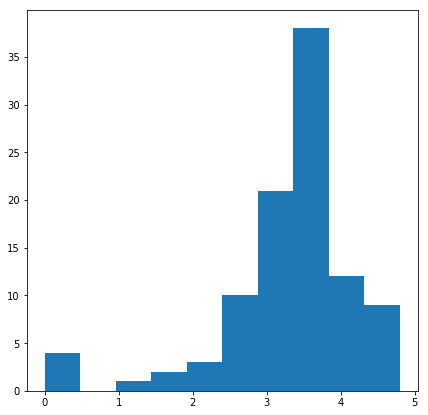

In [115]:
plt.figure(figsize=(7,7))
plt.hist(p)
plt.show()

In [116]:
def RMSE(r_real, r_pred):
    n = r_real.shape[0]
    return np.sqrt((1./n)*np.sum((r_real-r_pred)**2))

In [125]:
query

array([[ 3.,  0.,  0., ...,  0.,  0.,  0.]])

In [126]:
pred[mask]

IndexError: too many indices for array

In [121]:
mask = query>0

RMSE(pred[mask], query[mask])

TypeError: only integer scalar arrays can be converted to a scalar index